In [71]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters_gaussians.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

Meshcat url:  http://127.0.0.1:7013/static/


In [73]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 1
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in range(N_samples):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

draw_scene_tree_contents_meshcat(samples[0][0], zmq_url=vis.window.zmq_url, prefix="sample")

Loaded 1 scenes.


In [74]:
# Initialize a grammar with wide parameter guesses.
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=False
)
# Force parameter guesses for rules as wide as possible.
# TODO: Make this a grammar method.
for node_type in grammar.all_types:
    for xyz_param_dict, rot_param_dict in grammar.rule_params_by_node_type[node_type.__name__]:
        if "width" in xyz_param_dict.keys():
            xyz_param_dict["width"].set(torch.ones_like(xyz_param_dict["width"]()) * 5.)
        

def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")
    
def get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0,
            num_samples=20, subsample_step=1, hmc_strategy="NUTS"):
    draw_scene_tree_contents_meshcat(
        SceneTree.make_from_observed_nodes(observed_nodes), zmq_url=vis.window.zmq_url, prefix="observed"
    )
    
    # Use a MIP to get MAP structure.
    mip_results = infer_mle_tree_with_mip(
        grammar, observed_nodes, verbose=verbose>1, max_scene_extent_in_any_dir=10.
    )
    mip_optimized_tree = get_optimized_tree_from_mip_results(mip_results)
    if not mip_optimized_tree:
        return None
    
    draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
                                      
    # Use NLP to refine that to a MAP estimate.
    refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=verbose>1)
    refined_tree = refinement_results.refined_tree
    
    # And sample trees around that MAP estimate with the
    # same structure.
    # Langevin-esque:
    if hmc_strategy=="langevin":
        sampled_trees = do_fixed_structure_hmc_with_constraint_penalties(
            grammar, tree, num_samples=num_samples, subsample_step=subsample_step, verbose=1,
            kernel_type="HMC", num_steps=1, step_size=1E-3, adapt_step_size=True
        )
    # NUTS, defaults except limiting tree depth, to save on calls to
    # the slow model. Much slower, but should theoretically get much more
    # diversity as long as it doesn't diverge.
    elif hmc_strategy=="NUTS":
        sampled_trees = do_fixed_structure_hmc_with_constraint_penalties(
            grammar, tree, num_samples=num_samples, subsample_step=subsample_step, verbose=1,
            kernel_type="NUTS", max_tree_depth=4
        )
    else:
        raise ValueError(hmc_strategy)
    
    
    # Finally, subsample the sampled trees as requested and return
    # the sampled set.
    return sampled_trees

def collect_posterior_sample_sets(grammar, observed_node_sets):
    posterior_sample_sets = []
    for observed_nodes in tqdm(observed_node_sets, desc='Collecting posterior samples'):
        posterior_samples = get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0, hmc_strategy="NUTS", num_samples=20, subsample_step=1)
        if posterior_samples is not None:
            posterior_sample_sets.append(posterior_samples)
    return posterior_sample_sets
posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)

Sample: 100%|██████████| 30/30 [00:30,  1.03s/it, step size=2.60e-03, acc. prob=0.896]



                                                                        mean       std    median     25.0%     75.0%     n_eff     r_hat
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[0]      0.80      0.02      0.80      0.80      0.82      5.36      1.00
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[1]      0.72      0.02      0.71      0.70      0.71      3.20      1.83
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[2]     -0.00      0.01     -0.00     -0.01      0.00   1343.53      0.95
        Desk_84/ObjectCluster_153/GaussianChordOffsetRule_theta[0]     -1.07      0.01     -1.07     -1.07     -1.05     10.57      1.11
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[0]      0.34      0.01      0.33      0.33      0.34      9.58      1.18
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[1]      0.40      0.02      0.40      0.37      0.40      6.41      0.95
    Desk_84/ObjectCluster_154/AxisAligne

In [75]:
for k, tree in enumerate(posterior_sample_sets[-1]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="guesses/%d" % k)

In [76]:
torch.save(grammar, "/tmp/test_saved_grammar.torch")
orig_grammar = torch.load("/tmp/test_saved_grammar.torch")

In [77]:
# And now do gradient descent on the grammar parameters
# by summing the score of all of those trees.

def fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets):
    # Reattach tree params to prepare for grad descent.
    tree_set = sum(posterior_sample_sets, [])
    tree_set = [deepcopy(tree) for tree in tree_set]

    def calc_mean_score(tree_set):
        total_score = 0.
        total_k = 0.
        for tree in tree_set:
            total_score = total_score + tree.score()
            total_k += 1
        return total_score / total_k

    log_by_node_type = {node_type.__name__: [] for node_type in grammar.all_types}
    def log_params(grammar):
        for node_type_name, params in grammar.params_by_node_type.items():
            if params is not None:
                log_by_node_type[node_type_name].append(params().detach())

    optimizer = torch.optim.Adam(grammar.parameters(), lr=0.01)
    pbar = tqdm(range(50), desc="Optimizing parameters")
    score_history = []
    for step_k in pbar:
        # Update parameter settings
        log_params(grammar)
        for tree in tree_set:
            grammar.update_tree_grammar_parameters(tree)
        score = calc_mean_score(tree_set)
        score_history.append(score)
        # Gradient step
        optimizer.zero_grad()
        (-score).backward(retain_graph=True)
        optimizer.step()
        pbar.set_description("Mean score %2.2f" % score)
    return grammar, score_history

if 0:
    grammar, score_history = fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets)
    plt.plot(score_history)
    plt.xlabel("Step")
    plt.title("Score history")
    print("**********************************\n"
          "**********  BEFORE ***************\n"
          "************************************")
    orig_grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  AFTER ***************\n"
          "************************************")
    grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  TRUTH ***************\n"
          "************************************")
    ground_truth_grammar.print_params(node_names=["Desk"])

In [ ]:
state_dict_history = []
for iter_k in range(10):
    state_dict_history.append(deepcopy(grammar.state_dict()))
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)
    fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets)    
state_dict_history.append(deepcopy(grammar.state_dict()))

Sample: 100%|██████████| 30/30 [00:30,  1.02s/it, step size=2.83e-03, acc. prob=0.896]



                                                                        mean       std    median     25.0%     75.0%     n_eff     r_hat
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[0]      0.80      0.01      0.80      0.80      0.80      6.37      1.82
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[1]      0.73      0.01      0.73      0.73      0.74     10.03      1.06
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[2]     -0.00      0.01     -0.00     -0.00      0.00    -28.55      0.96
        Desk_84/ObjectCluster_153/GaussianChordOffsetRule_theta[0]     -0.91      0.04     -0.91     -0.93     -0.88      2.74      2.13
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[0]      0.34      0.03      0.35      0.35      0.38      3.19      1.66
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[1]      0.43      0.02      0.43      0.42      0.45      9.18      0.96
    Desk_84/ObjectCluster_154/AxisAligne

Optimizing parameters:   0%|          | 0/50 [00:00<?, ?it/s]

Sample: 100%|██████████| 30/30 [00:30,  1.03s/it, step size=2.31e-03, acc. prob=0.929]



                                                                        mean       std    median     25.0%     75.0%     n_eff     r_hat
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[0]      0.79      0.02      0.79      0.78      0.80      3.17      1.94
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[1]      0.72      0.01      0.72      0.72      0.74      5.23      0.96
    Desk_84/ObjectCluster_153/AxisAlignedGaussianOffsetRule_xyz[2]     -0.00      0.01     -0.00     -0.00      0.01    109.80      1.00
        Desk_84/ObjectCluster_153/GaussianChordOffsetRule_theta[0]     -1.03      0.04     -1.03     -1.03     -0.99      2.45      2.63
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[0]      0.30      0.02      0.29      0.28      0.30     10.34      0.97
    Desk_84/ObjectCluster_154/AxisAlignedGaussianOffsetRule_xyz[1]      0.42      0.02      0.42      0.41      0.43      7.75      0.99
    Desk_84/ObjectCluster_154/AxisAligne

Optimizing parameters:   0%|          | 0/50 [00:00<?, ?it/s]

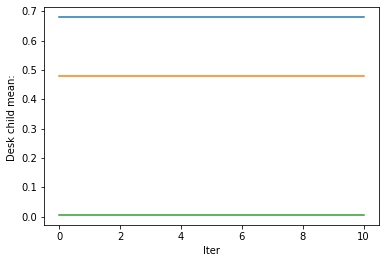

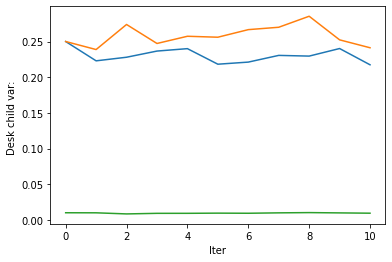

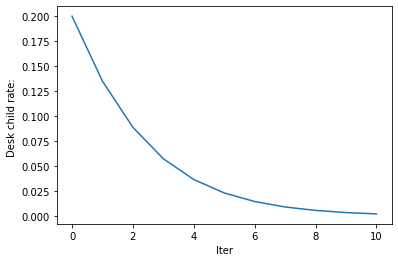

In [83]:
# Plot a couple of interesting parameters
param_getters_of_interest = {
    "Desk child mean: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["mean"]().detach().numpy(),
    "Desk child var: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["variance"]().detach().numpy(),
    "Desk child rate: ": lambda x: x.params_by_node_type["Desk"]().detach().numpy()
}

for key, getter in param_getters_of_interest.items():
    plt.figure()
    history = []
    for state_dict in state_dict_history:
        grammar.load_state_dict(state_dict)
        history.append(getter(grammar))

    plt.plot(history)
    plt.xlabel("Iter")
    plt.ylabel(key)
